In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import xarray as xr
import xrbeall
from dask.diagnostics import ProgressBar

In the following example 2 signals containing harmonics with a cubic dispersion relation are created.
The second signal is shifted by a spatial lag according to the wavenumber and a random phase.

$$s_1(t) = \mathrm{cos}(2\pi f t)$$
$$s_2(t) = \mathrm{cos}(2\pi f t + k \Delta x + \varphi)$$
where $k \propto f^3$ and $\varphi \sim N(0, 1)$.

In [3]:
ds = xr.Dataset()
ds.coords['time'], dt = np.linspace(0, 1, 2**18, retstep=True)
f_nyq = 0.5/dt   # Nyquist frequency
nf = 2**8
ds.coords['frequency'] = np.linspace(-f_nyq, f_nyq, nf)
ds.coords['k'] = (ds.frequency/f_nyq)**3
ds.coords['phase'] = ('frequency', np.random.normal(size=nf))
k_nyq = ds.k.max()  # Highest k we want to resolve
Dx = (2*np.pi / k_nyq) / 2  # Sampling 2*k_nyq
ds['sig1'] = np.cos(2*np.pi*ds.time*ds.frequency).sum(dim='frequency')
ds['sig2'] = np.cos(2*np.pi*ds.time*ds.frequency + Dx*ds.k + ds.phase).sum(dim='frequency')
ds

<xarray.Dataset>
Dimensions:    (frequency: 256, time: 262144)
Coordinates:
  * time       (time) float64 0.0 3.815e-06 7.629e-06 1.144e-05 ... 1.0 1.0 1.0
  * frequency  (frequency) float64 -1.311e+05 -1.3e+05 ... 1.3e+05 1.311e+05
    k          (frequency) float64 -1.0 -0.9767 -0.9537 ... 0.9537 0.9767 1.0
    phase      (frequency) float64 -0.2327 0.08544 -0.1527 ... 0.06654 -0.4902
Data variables:
    sig1       (time) float64 256.0 -1.0 1.0 -1.0 1.0 ... 256.0 -1.0 1.0 -1.0
    sig2       (time) float64 92.59 21.86 4.446 12.3 ... 92.59 21.86 4.446 12.3

In [4]:
beall_ds = xrbeall.beall_fft(ds.sig1, ds.sig2, Dx, 
                             NK=nf,
                             nperseg=nf,  # set FFT window to same res
                             return_onesided=False,  # full f spectra
                            )
beall_ds

<xarray.Dataset>
Dimensions:     (frequency: 256, time: 1024, wavenumber: 256)
Coordinates:
  * frequency   (frequency) float64 0.0 1.024e+03 ... -2.048e+03 -1.024e+03
  * wavenumber  (wavenumber) float64 -1.0 -0.9922 -0.9843 ... 0.9843 0.9922 1.0
  * time        (time) float64 0.0004883 0.001465 0.002441 ... 0.9985 0.9995
Data variables:
    S_K_f       (frequency, wavenumber) float64 dask.array<shape=(256, 256), chunksize=(1, 256)>
    S           (frequency, time) float64 3.926e-05 0.0003251 ... 9.794e-05
    S1          (frequency, time) float64 5.86e-11 0.0006444 ... 0.0001646
    S2          (frequency, time) float64 7.851e-05 5.829e-06 ... 3.128e-05
    H           (frequency, time) complex128 (6.782745442625207e-08+0j) ... (-5.7100703358512314e-05-4.345325085786745e-05j)

The actual vectorized computation is contained in a Dask array and can be parallelized.

In [5]:
with ProgressBar():
    S_K_f = beall_ds.S_K_f.compute()

[#############                           ] | 34% Completed |  0.3s

/home/ondrej/anaconda/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  2.3s


/home/ondrej/anaconda/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


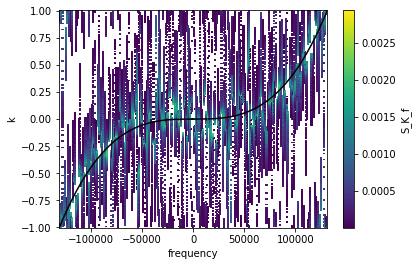

In [6]:
beall_ds.S_K_f.sortby('frequency').compute().plot(x='frequency', y='wavenumber')
ds.k.plot.line('k')